In [78]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy import signal
from scipy.fft import fft, ifft, ifftshift

In [110]:
"""data_noise = r"..\data\sensors_noise.npz"
data_noise = np.load(data_noise)['arr_0']

data = r"..\data\sensors_square_9.npz"
data = np.load(data)['arr_0']"""

data_noise = r"..\data\avstand_1_noise.npz"
data_noise = np.load(data_noise)['data']

data = r"..\data\avstand_1.npz"
data = np.load(data)['data']


w = 1000 
sampling_rate = 204800
"""
data = data[8, :, :w]
data_noise = data_noise[0, :, :w]"""

data = data[:,:w]
data_noise = data_noise[:,:w]


<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\malan\AppData\Local\Temp\ipykernel_8884\2816769103.py:1: SyntaxWarning: invalid escape sequence '\d'
  """data_noise = r"..\data\sensors_noise.npz"


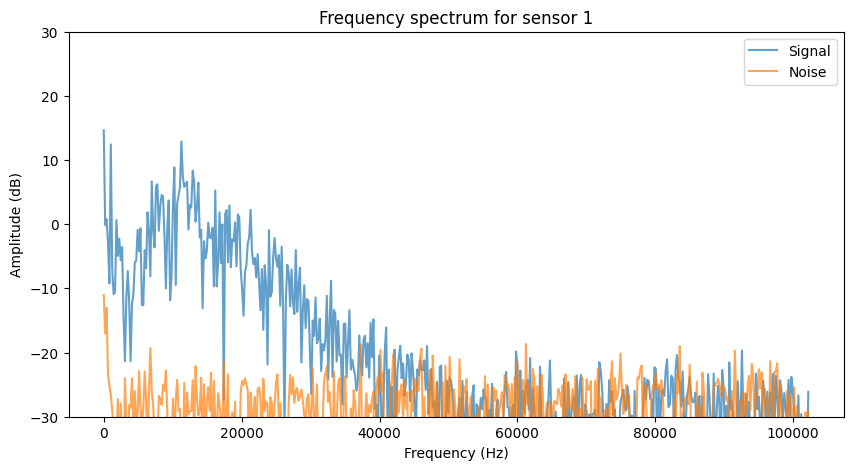

In [111]:
timestep = 1/sampling_rate
frequencies = np.fft.fftfreq(w, d=timestep)
frequencies = frequencies[:w//2]

data_fft = np.fft.fft(data[0])[:w//2]
noise_fft = np.fft.fft(data_noise[0])[:w//2]

fig, ax = plt.subplots(1,1, figsize=(10, 5))

ax.plot(frequencies, 20*np.log10(np.abs(data_fft)), label='Signal', alpha=0.7)
ax.plot(frequencies, 20*np.log10(np.abs(noise_fft)), label='Noise', alpha=0.7)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude (dB)')
ax.set_title('Frequency spectrum for sensor 1')
ax.set_ylim(-30,30)
ax.legend()

                       



##### Plotting the signal

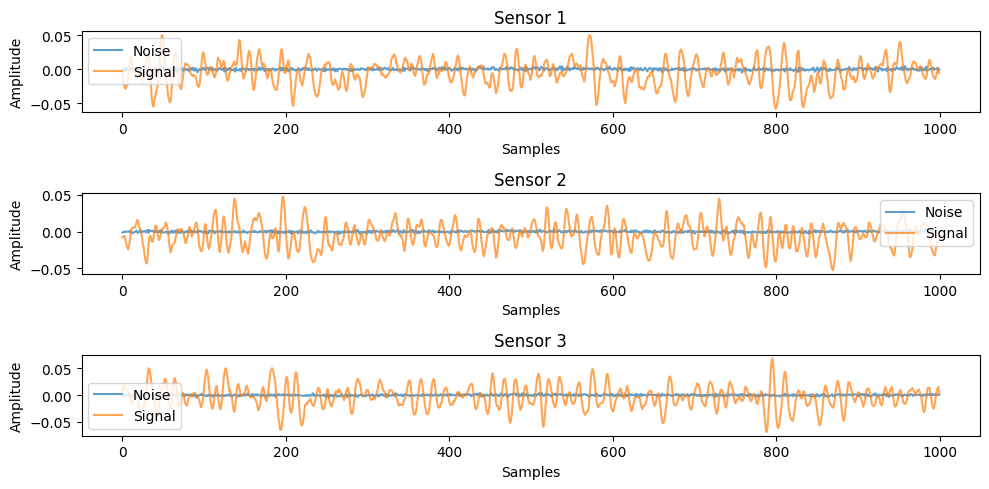

In [112]:
fig, ax = plt.subplots(3,1,figsize=(10,5))
ax = ax.ravel()
for i in range(3):
    ax[i].plot(data_noise[i], label='Noise', alpha=0.7)
    ax[i].plot(data[i], label='Signal', alpha=0.7)
    ax[i].set_title(f'Sensor {i+1}')
    ax[i].set_xlabel('Samples')
    ax[i].set_ylabel('Amplitude')
    ax[i].legend()
    
    
plt.tight_layout()
plt.show()


##### Applying FIRWIN filter 

In [113]:
def truncate_time_shift(time_shift,length):
    index_0 = len(time_shift)/2
    start_index = int(index_0 - length/2)
    end_index = int(index_0 + length/2)
    time_shift = time_shift[start_index:end_index]
    return time_shift

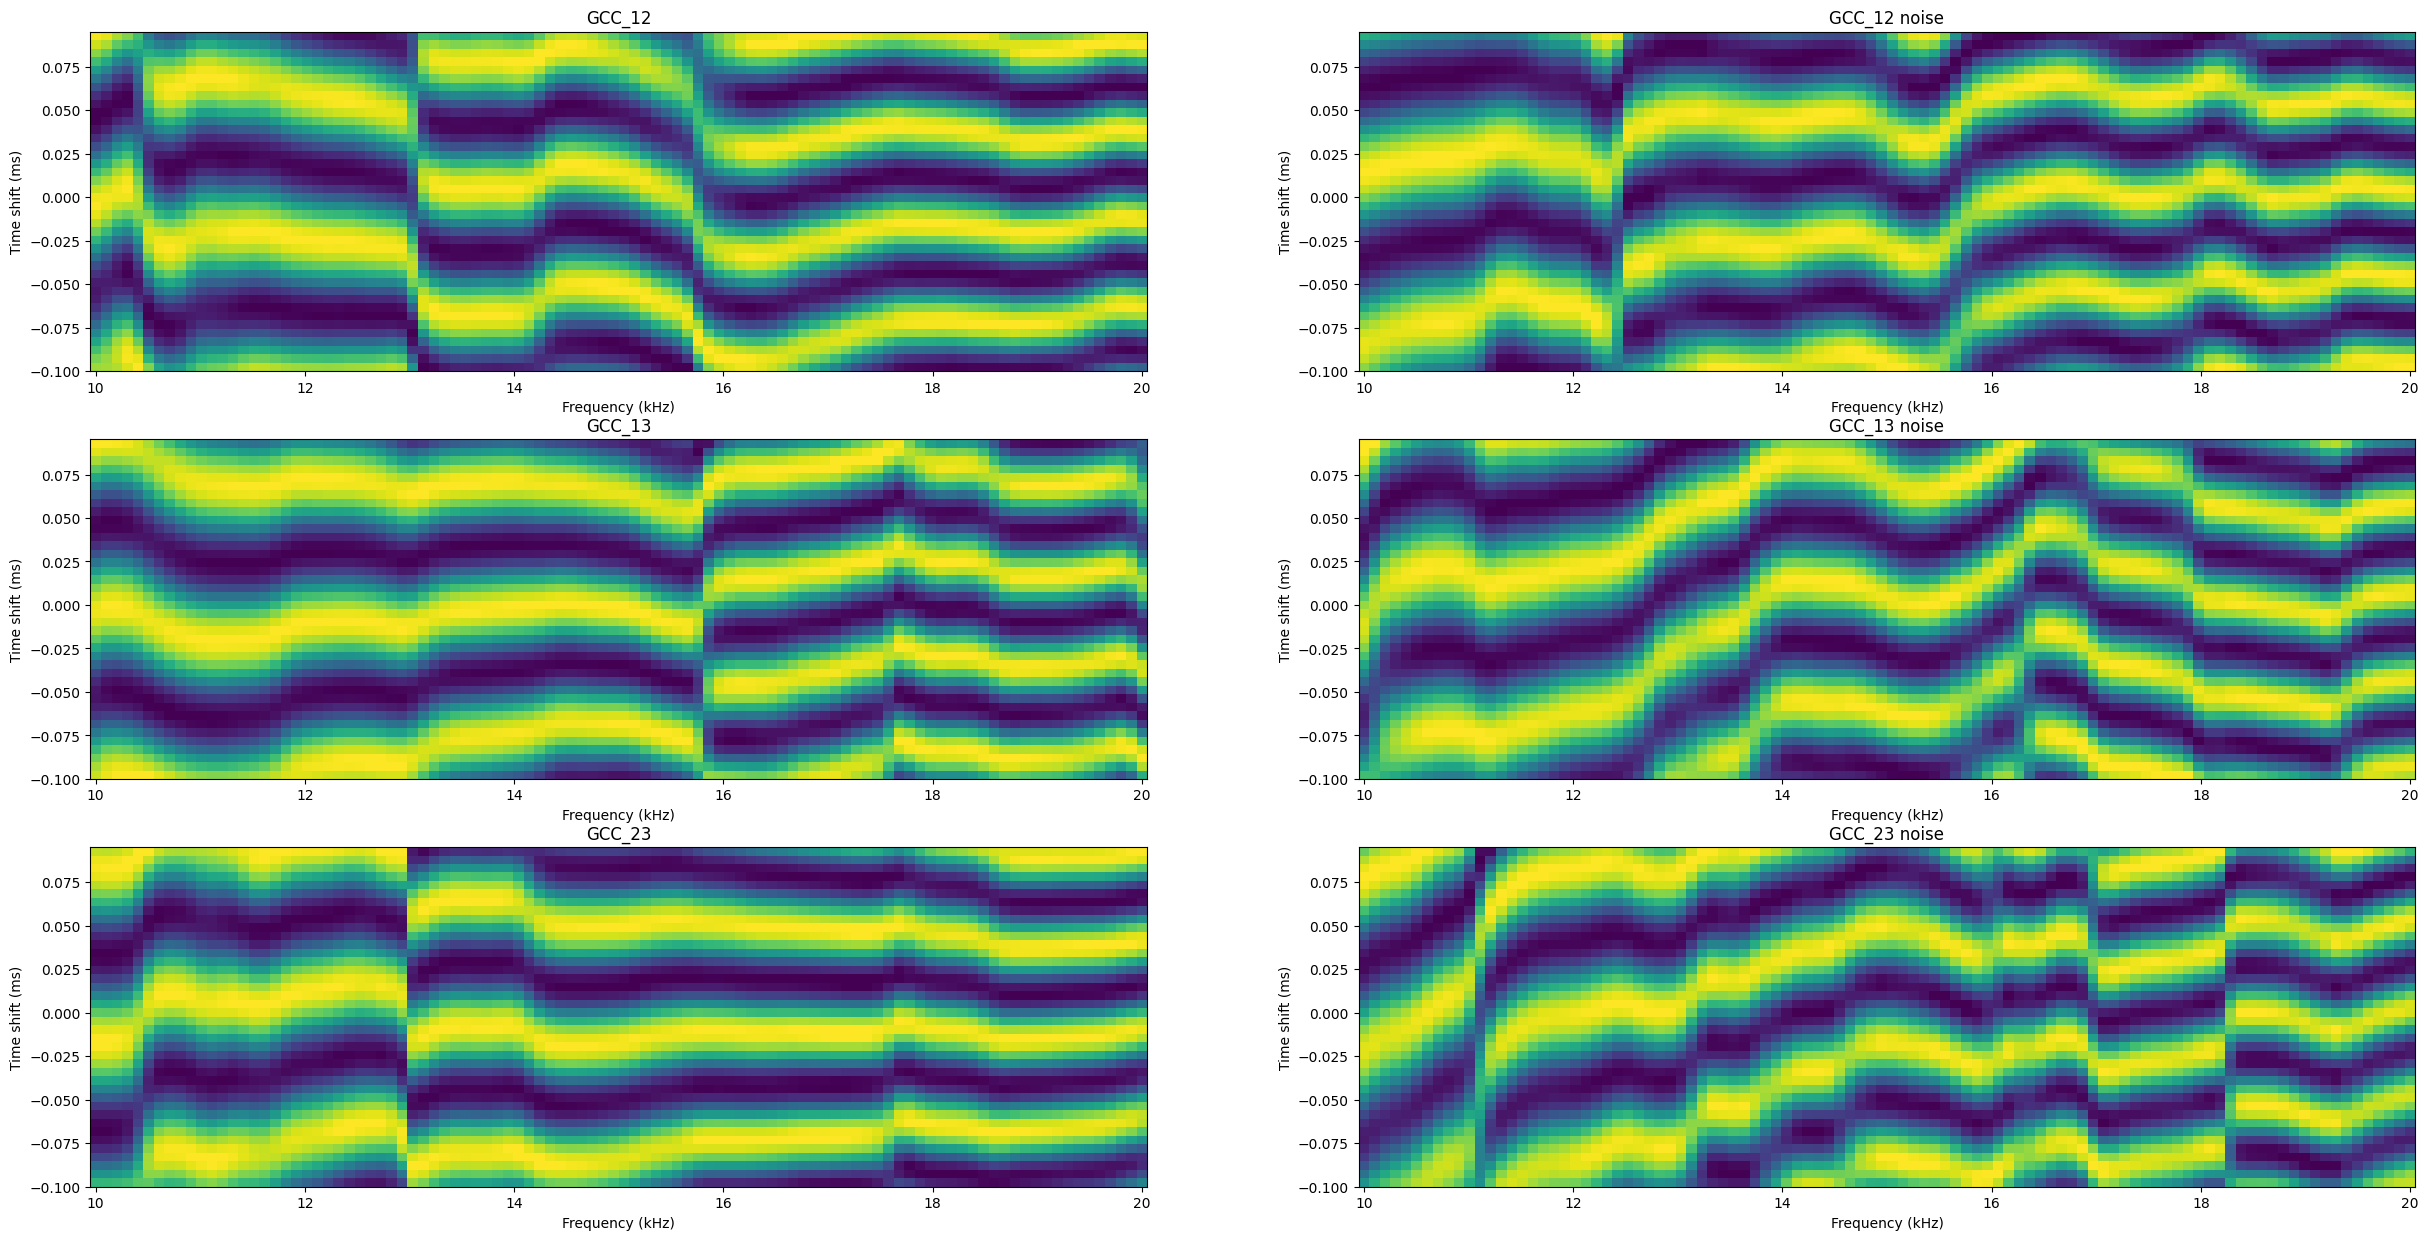

In [125]:
frequencies = np.linspace(10000, 20000, 100)
numtaps = 1001
truncate_length = 40
window_type = signal.windows.boxcar
beta = 1
correlation_type = np.real
output_folder = r"../testing_sinc_net"

band_width = 1000
filters = []



# creating filters bandpass
for frequency in frequencies:
    h = signal.firwin(numtaps, [frequency - band_width//2, frequency + band_width//2], fs=sampling_rate, pass_zero="bandpass")
    filters.append(h)



def GCC(sensor1, sensor2): 
    GCC_12 = []
    i = 0 
    for h in filters:
        s1 = signal.lfilter(h, 1.0, sensor1)
        s2 = signal.lfilter(h, 1.0, sensor2)
        '''
        frequency_spectrum_1 = np.fft.rfft(s1)
        frequency_spectrum_2 = np.fft.rfft(s2)

        fig, ax = plt.subplots(1,2,figsize=(20,5))

        ax[0].plot(np.abs(frequency_spectrum_1))
        ax[0].set_title('Frequency spectrum of sensor 1')
        ax[0].set_xlabel('Frequency (Hz)')
        ax[0].set_ylabel('Amplitude')

        ax[1].plot(np.abs(frequency_spectrum_2))
        ax[1].set_title('Frequency spectrum of sensor 2')
        ax[1].set_xlabel('Frequency (Hz)')
        ax[1].set_ylabel('Amplitude')
        ax[0].set_ylim(0,1)
        ax[1].set_ylim(0,1)
        
        

        title = f'Filter  frequency {frequencies[i]} Hz'    
        i += 1
        fig.suptitle(title)
        plt.savefig(f'{output_folder}/{title}.png')
        plt.close()'''



        window = window_type(len(s1))
        s1 = s1 * window
        s2 = s2 * window

        f_s1 = fft(s1)
        f_s2 = fft(s2)

        G12 = f_s1 * np.conj(f_s2)
        denom = abs(G12)
        denom[denom < 1e-6] = 1e-6
        f_s = G12 / denom**beta
        f_s =G12


        # Er f_s 1 
        cc12 = ifft(f_s)
        cc12 = ifftshift(cc12)

        cc12 = correlation_type(cc12)

        index_0 = len(cc12)/2
        start_index = int(index_0 - truncate_length/2)
        end_index = int(index_0 + truncate_length/2)
        cc12 = cc12[start_index:end_index]

        cc12 = cc12 / np.max(np.abs(cc12))
        GCC_12.append(cc12)
    GCC_12 = np.array(GCC_12)
    return GCC_12


sensor1_noise = data_noise[0]
sensor2_noise = data_noise[1]
sensor3_noise = data_noise[2]
dt = 1/sampling_rate
GCC_12_noise = GCC(sensor1_noise, sensor2_noise)
GCC_13_noise = GCC(sensor1_noise, sensor3_noise)
GCC_23_noise = GCC(sensor2_noise, sensor3_noise)


sensor1 = data[0]
sensor2 = data[1]
sensor3 = data[2]
GCC_12 = GCC(sensor1, sensor2)
GCC_13 = GCC(sensor1, sensor3)
GCC_23 = GCC(sensor2, sensor3)



time_shifts = np.arange(-w*dt,w*dt,dt)
time_shifts = truncate_time_shift(time_shifts, truncate_length)


fig, ax = plt.subplots(3,2,figsize=(30,15))
ax = ax.ravel()


ax[0].set_title('GCC_12')
ax[0].set_xlabel('Frequency (kHz)')
ax[0].set_ylabel('Time shift (ms)')
ax[0].pcolormesh(frequencies/1000, time_shifts*1000, GCC_12.T, shading='auto')

ax[1].set_title('GCC_12 noise')
ax[1].set_xlabel('Frequency (kHz)')
ax[1].set_ylabel('Time shift (ms)')
ax[1].pcolormesh(frequencies/1000, time_shifts*1000, GCC_12_noise.T, shading='auto')

ax[2].set_title('GCC_13')
ax[2].set_xlabel('Frequency (kHz)')
ax[2].set_ylabel('Time shift (ms)')
ax[2].pcolormesh(frequencies/1000, time_shifts*1000, GCC_13.T, shading='auto')

ax[3].set_title('GCC_13 noise')
ax[3].set_xlabel('Frequency (kHz)')
ax[3].set_ylabel('Time shift (ms)')
ax[3].pcolormesh(frequencies/1000, time_shifts*1000, GCC_13_noise.T, shading='auto')

ax[4].set_title('GCC_23')
ax[4].set_xlabel('Frequency (kHz)')
ax[4].set_ylabel('Time shift (ms)')
ax[4].pcolormesh(frequencies/1000, time_shifts*1000, GCC_23.T, shading='auto')

ax[5].set_title('GCC_23 noise')
ax[5].set_xlabel('Frequency (kHz)')
ax[5].set_ylabel('Time shift (ms)')
ax[5].pcolormesh(frequencies/1000, time_shifts*1000, GCC_23_noise.T, shading='auto')

plt.savefig(f'{output_folder}/GCC.png')


#### Auto Correlation

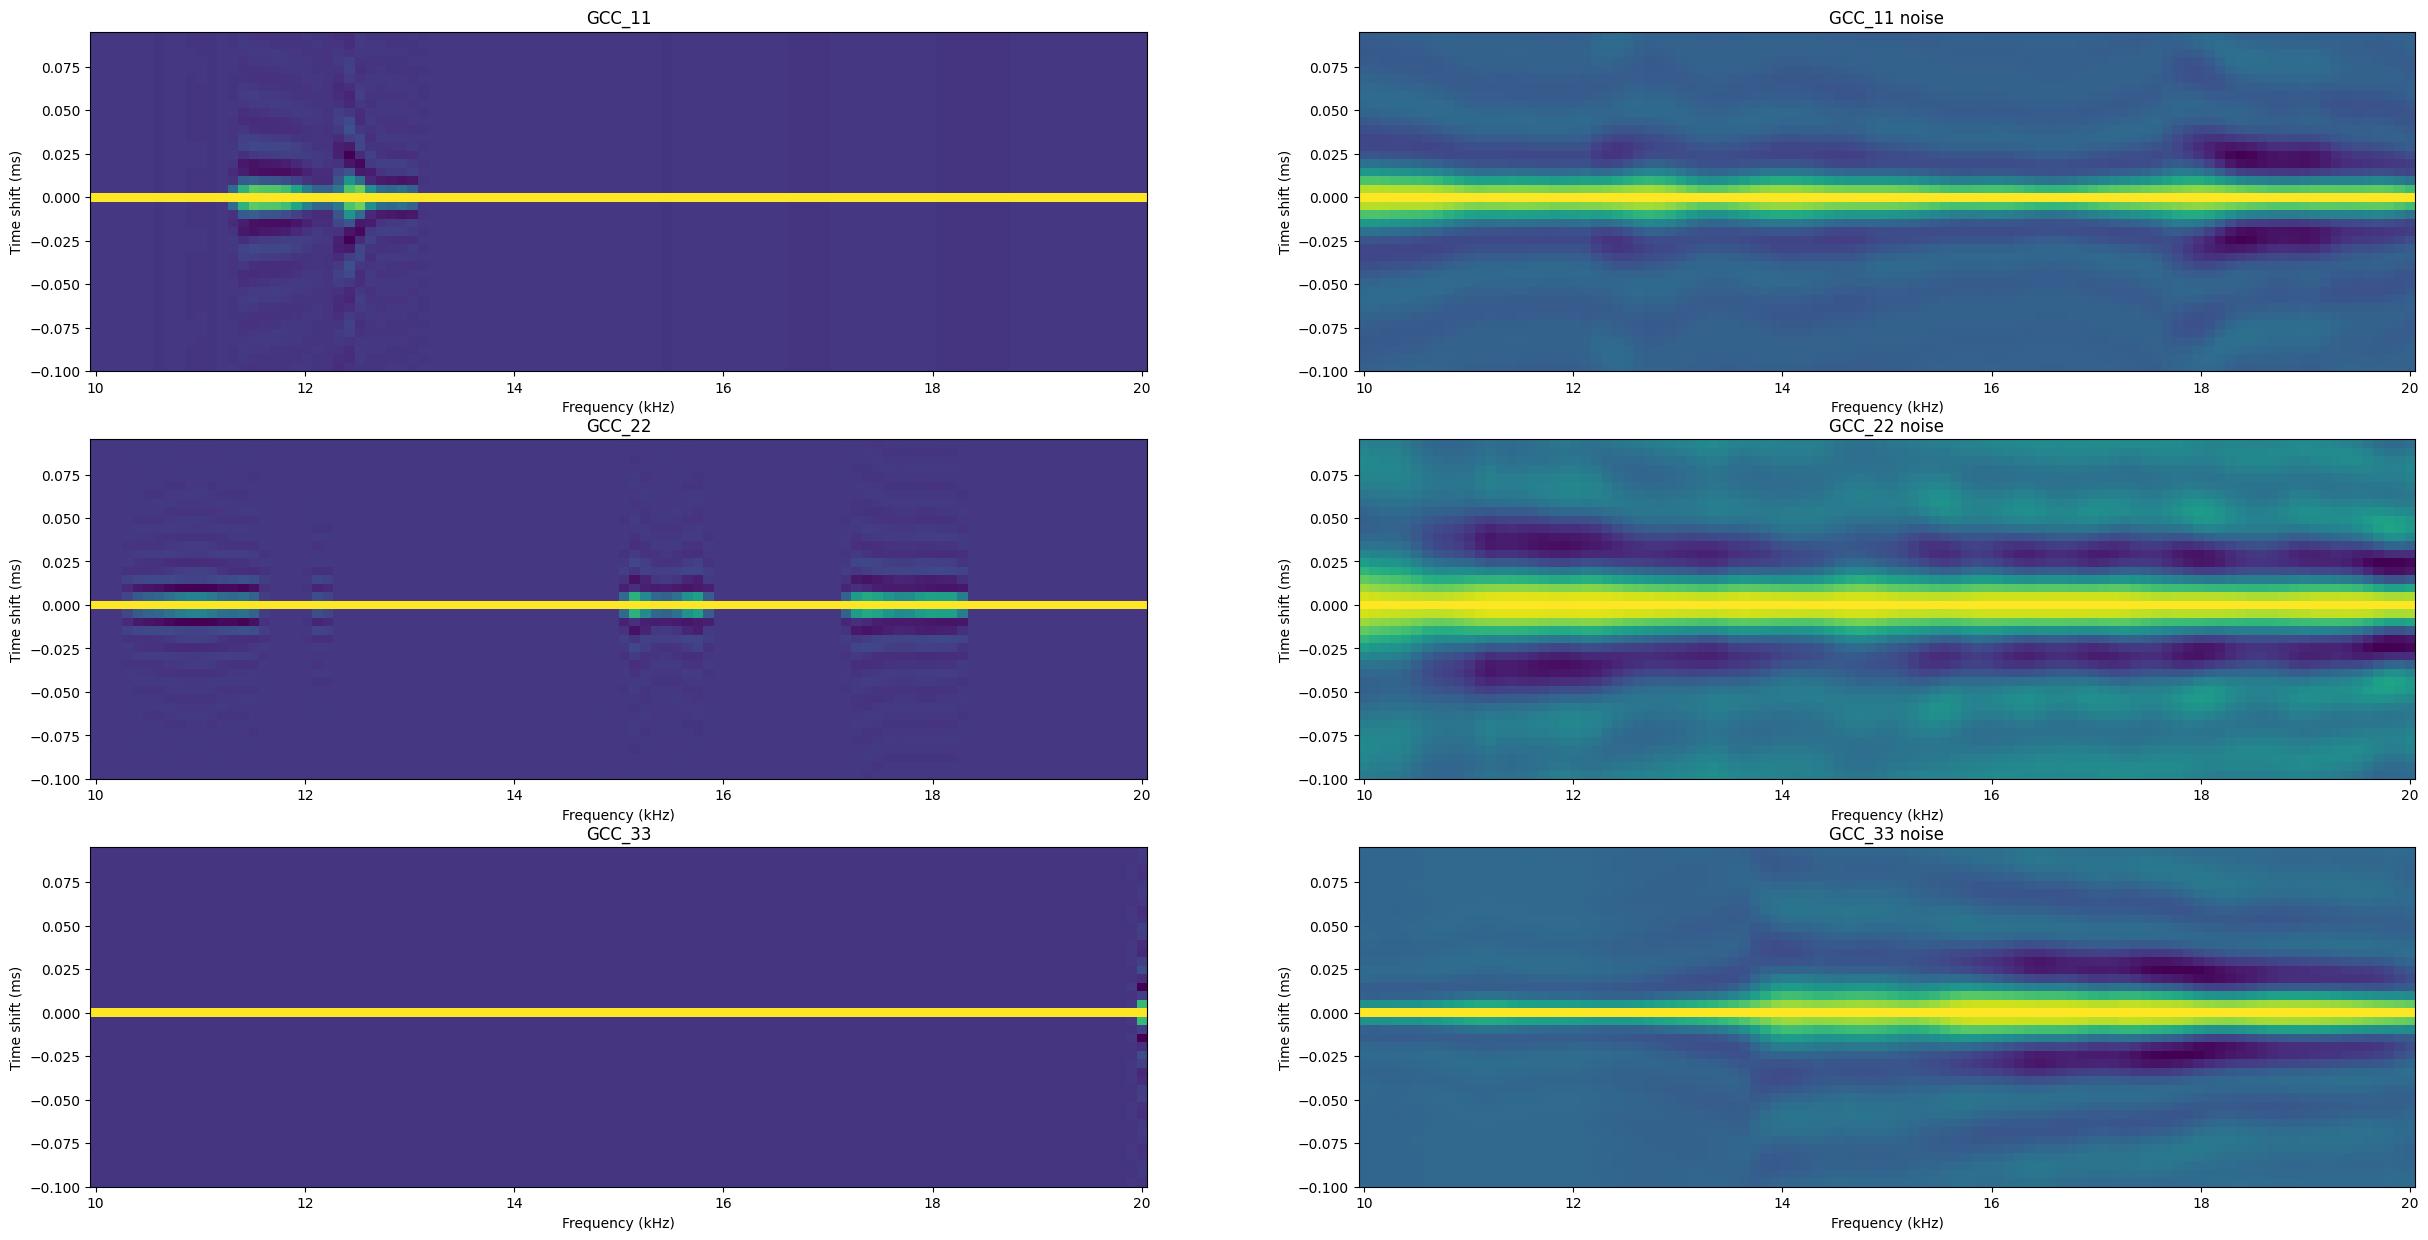

In [115]:
frequencies = np.linspace(10000, 20000, 100)
numtaps = 1001
truncate_length = 40
window_type = signal.windows.boxcar
beta = 1
correlation_type = np.real
output_folder = r"../testing_sinc_net"

band_width = 10000
filters = []



# creating filters bandpass
for frequency in frequencies:
    h = signal.firwin(numtaps, [frequency - band_width//2, frequency + band_width//2], fs=sampling_rate, pass_zero="bandpass")
    filters.append(h)



def GCC(sensor1, sensor2): 
    GCC_12 = []
    i = 0 
    for h in filters:
        s1 = signal.lfilter(h, 1.0, sensor1)
        s2 = signal.lfilter(h, 1.0, sensor2)
        '''
        frequency_spectrum_1 = np.fft.rfft(s1)
        frequency_spectrum_2 = np.fft.rfft(s2)

        fig, ax = plt.subplots(1,2,figsize=(20,5))

        ax[0].plot(np.abs(frequency_spectrum_1))
        ax[0].set_title('Frequency spectrum of sensor 1')
        ax[0].set_xlabel('Frequency (Hz)')
        ax[0].set_ylabel('Amplitude')

        ax[1].plot(np.abs(frequency_spectrum_2))
        ax[1].set_title('Frequency spectrum of sensor 2')
        ax[1].set_xlabel('Frequency (Hz)')
        ax[1].set_ylabel('Amplitude')
        ax[0].set_ylim(0,1)
        ax[1].set_ylim(0,1)
        
        

        title = f'Filter  frequency {frequencies[i]} Hz'    
        i += 1
        fig.suptitle(title)
        plt.savefig(f'{output_folder}/{title}.png')
        plt.close()'''



        window = window_type(len(s1))
        s1 = s1 * window
        s2 = s2 * window

        f_s1 = fft(s1)
        f_s2 = fft(s2)

        G12 = f_s1 * np.conj(f_s2)
        denom = abs(G12)
        denom[denom < 1e-6] = 1e-6
        f_s = G12 / denom**beta


        # Er f_s 1 
        cc12 = ifft(f_s)
        cc12 = ifftshift(cc12)

        cc12 = correlation_type(cc12)

        index_0 = len(cc12)/2
        start_index = int(index_0 - truncate_length/2)
        end_index = int(index_0 + truncate_length/2)
        cc12 = cc12[start_index:end_index]

        cc12 = cc12 / np.max(np.abs(cc12))
        GCC_12.append(cc12)
    GCC_12 = np.array(GCC_12)
    return GCC_12


sensor1_noise = data_noise[0]
sensor2_noise = data_noise[1]
sensor3_noise = data_noise[2]
dt = 1/sampling_rate
GCC_12_noise = GCC(sensor1_noise, sensor1_noise)
GCC_13_noise = GCC(sensor2_noise, sensor2_noise)
GCC_23_noise = GCC(sensor3_noise, sensor3_noise)


sensor1 = data[0]
sensor2 = data[1]
sensor3 = data[2]
GCC_12 = GCC(sensor1, sensor1)
GCC_13 = GCC(sensor2, sensor2)
GCC_23 = GCC(sensor3, sensor3)



time_shifts = np.arange(-w*dt,w*dt,dt)
time_shifts = truncate_time_shift(time_shifts, truncate_length)


fig, ax = plt.subplots(3,2,figsize=(30,15))
ax = ax.ravel()


ax[0].set_title('GCC_11')
ax[0].set_xlabel('Frequency (kHz)')
ax[0].set_ylabel('Time shift (ms)')
ax[0].pcolormesh(frequencies/1000, time_shifts*1000, GCC_12.T, shading='auto')

ax[1].set_title('GCC_11 noise')
ax[1].set_xlabel('Frequency (kHz)')
ax[1].set_ylabel('Time shift (ms)')
ax[1].pcolormesh(frequencies/1000, time_shifts*1000, GCC_12_noise.T, shading='auto')

ax[2].set_title('GCC_22')
ax[2].set_xlabel('Frequency (kHz)')
ax[2].set_ylabel('Time shift (ms)')
ax[2].pcolormesh(frequencies/1000, time_shifts*1000, GCC_13.T, shading='auto')

ax[3].set_title('GCC_22 noise')
ax[3].set_xlabel('Frequency (kHz)')
ax[3].set_ylabel('Time shift (ms)')
ax[3].pcolormesh(frequencies/1000, time_shifts*1000, GCC_13_noise.T, shading='auto')

ax[4].set_title('GCC_33')
ax[4].set_xlabel('Frequency (kHz)')
ax[4].set_ylabel('Time shift (ms)')
ax[4].pcolormesh(frequencies/1000, time_shifts*1000, GCC_23.T, shading='auto')

ax[5].set_title('GCC_33 noise')
ax[5].set_xlabel('Frequency (kHz)')
ax[5].set_ylabel('Time shift (ms)')
ax[5].pcolormesh(frequencies/1000, time_shifts*1000, GCC_23_noise.T, shading='auto')

plt.savefig(f'{output_folder}/GCC.png')


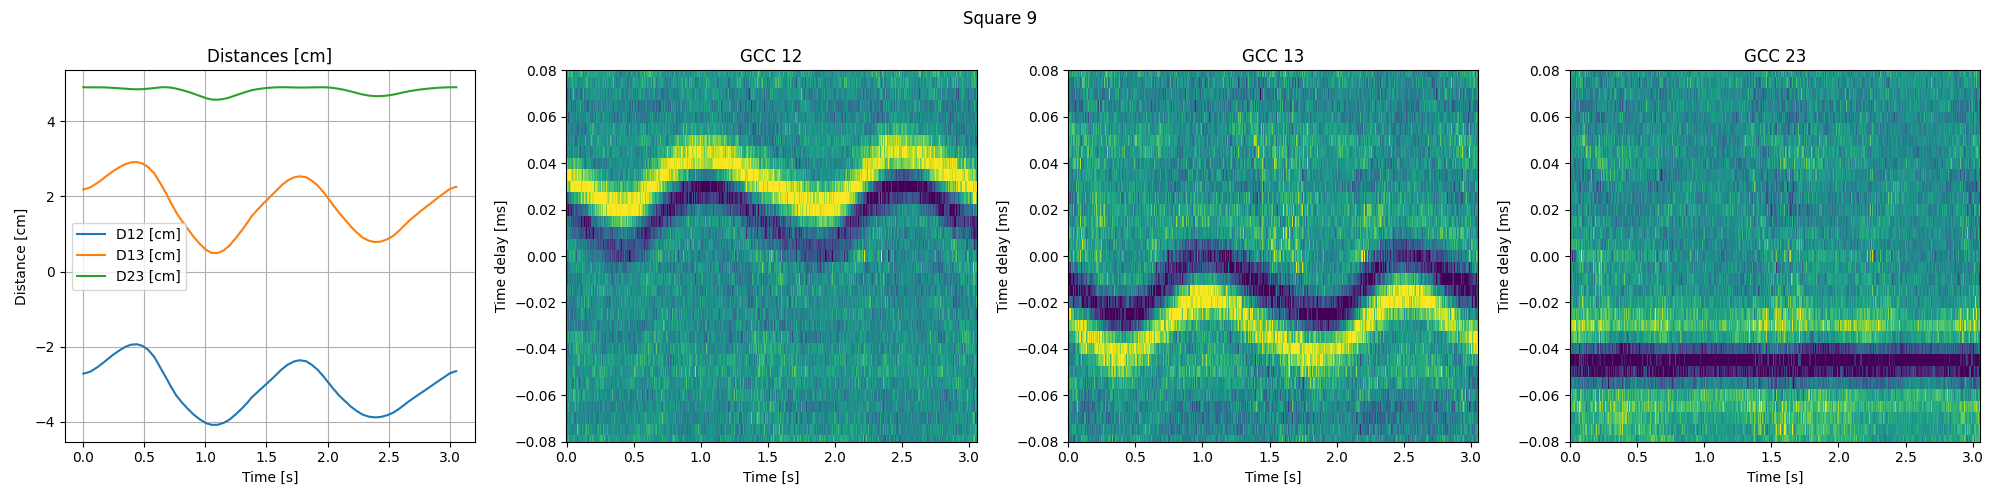

In [118]:
def create_gcc(sensor_1, sensor_2): 
    '''
    Inputs: 
    sensor_1: sensor 1 data
    sensor_2: sensor 2 data
    window_size: window size in samples
    step_size: step size in samples
    truncate_length: length of truncated output in samples
    window_type: window type. Example: signal.windows.boxcar
    beta: power of denominator
    correlation_type: real, imag or abs

    Outputs:
    GCC: cross correlation 
    '''


    window = window_type(len(sensor_1))
    sensor_1 = sensor_1 * window
    sensor_2 = sensor_2 * window

    f_s1 = fft(sensor_1)
    f_s2 = fft(sensor_2)



    G12 = f_s1 * np.conj(f_s2)
    denom = abs(G12)
    max_denom = 1e-6
    denom[denom < max_denom] = max_denom

    f_s = G12 / denom**beta


    # Er f_s 1 
    cc12 = ifft(f_s)
    cc12 = ifftshift(cc12)

    cc12 = correlation_type(cc12)

    index_0 = len(cc12)/2
    start_index = int(index_0 - truncate_length/2)
    end_index = int(index_0 + truncate_length/2)
    cc12 = cc12[start_index:end_index]

    #cc12 = cc12 / np.max(np.abs(cc12))
    
    return cc12



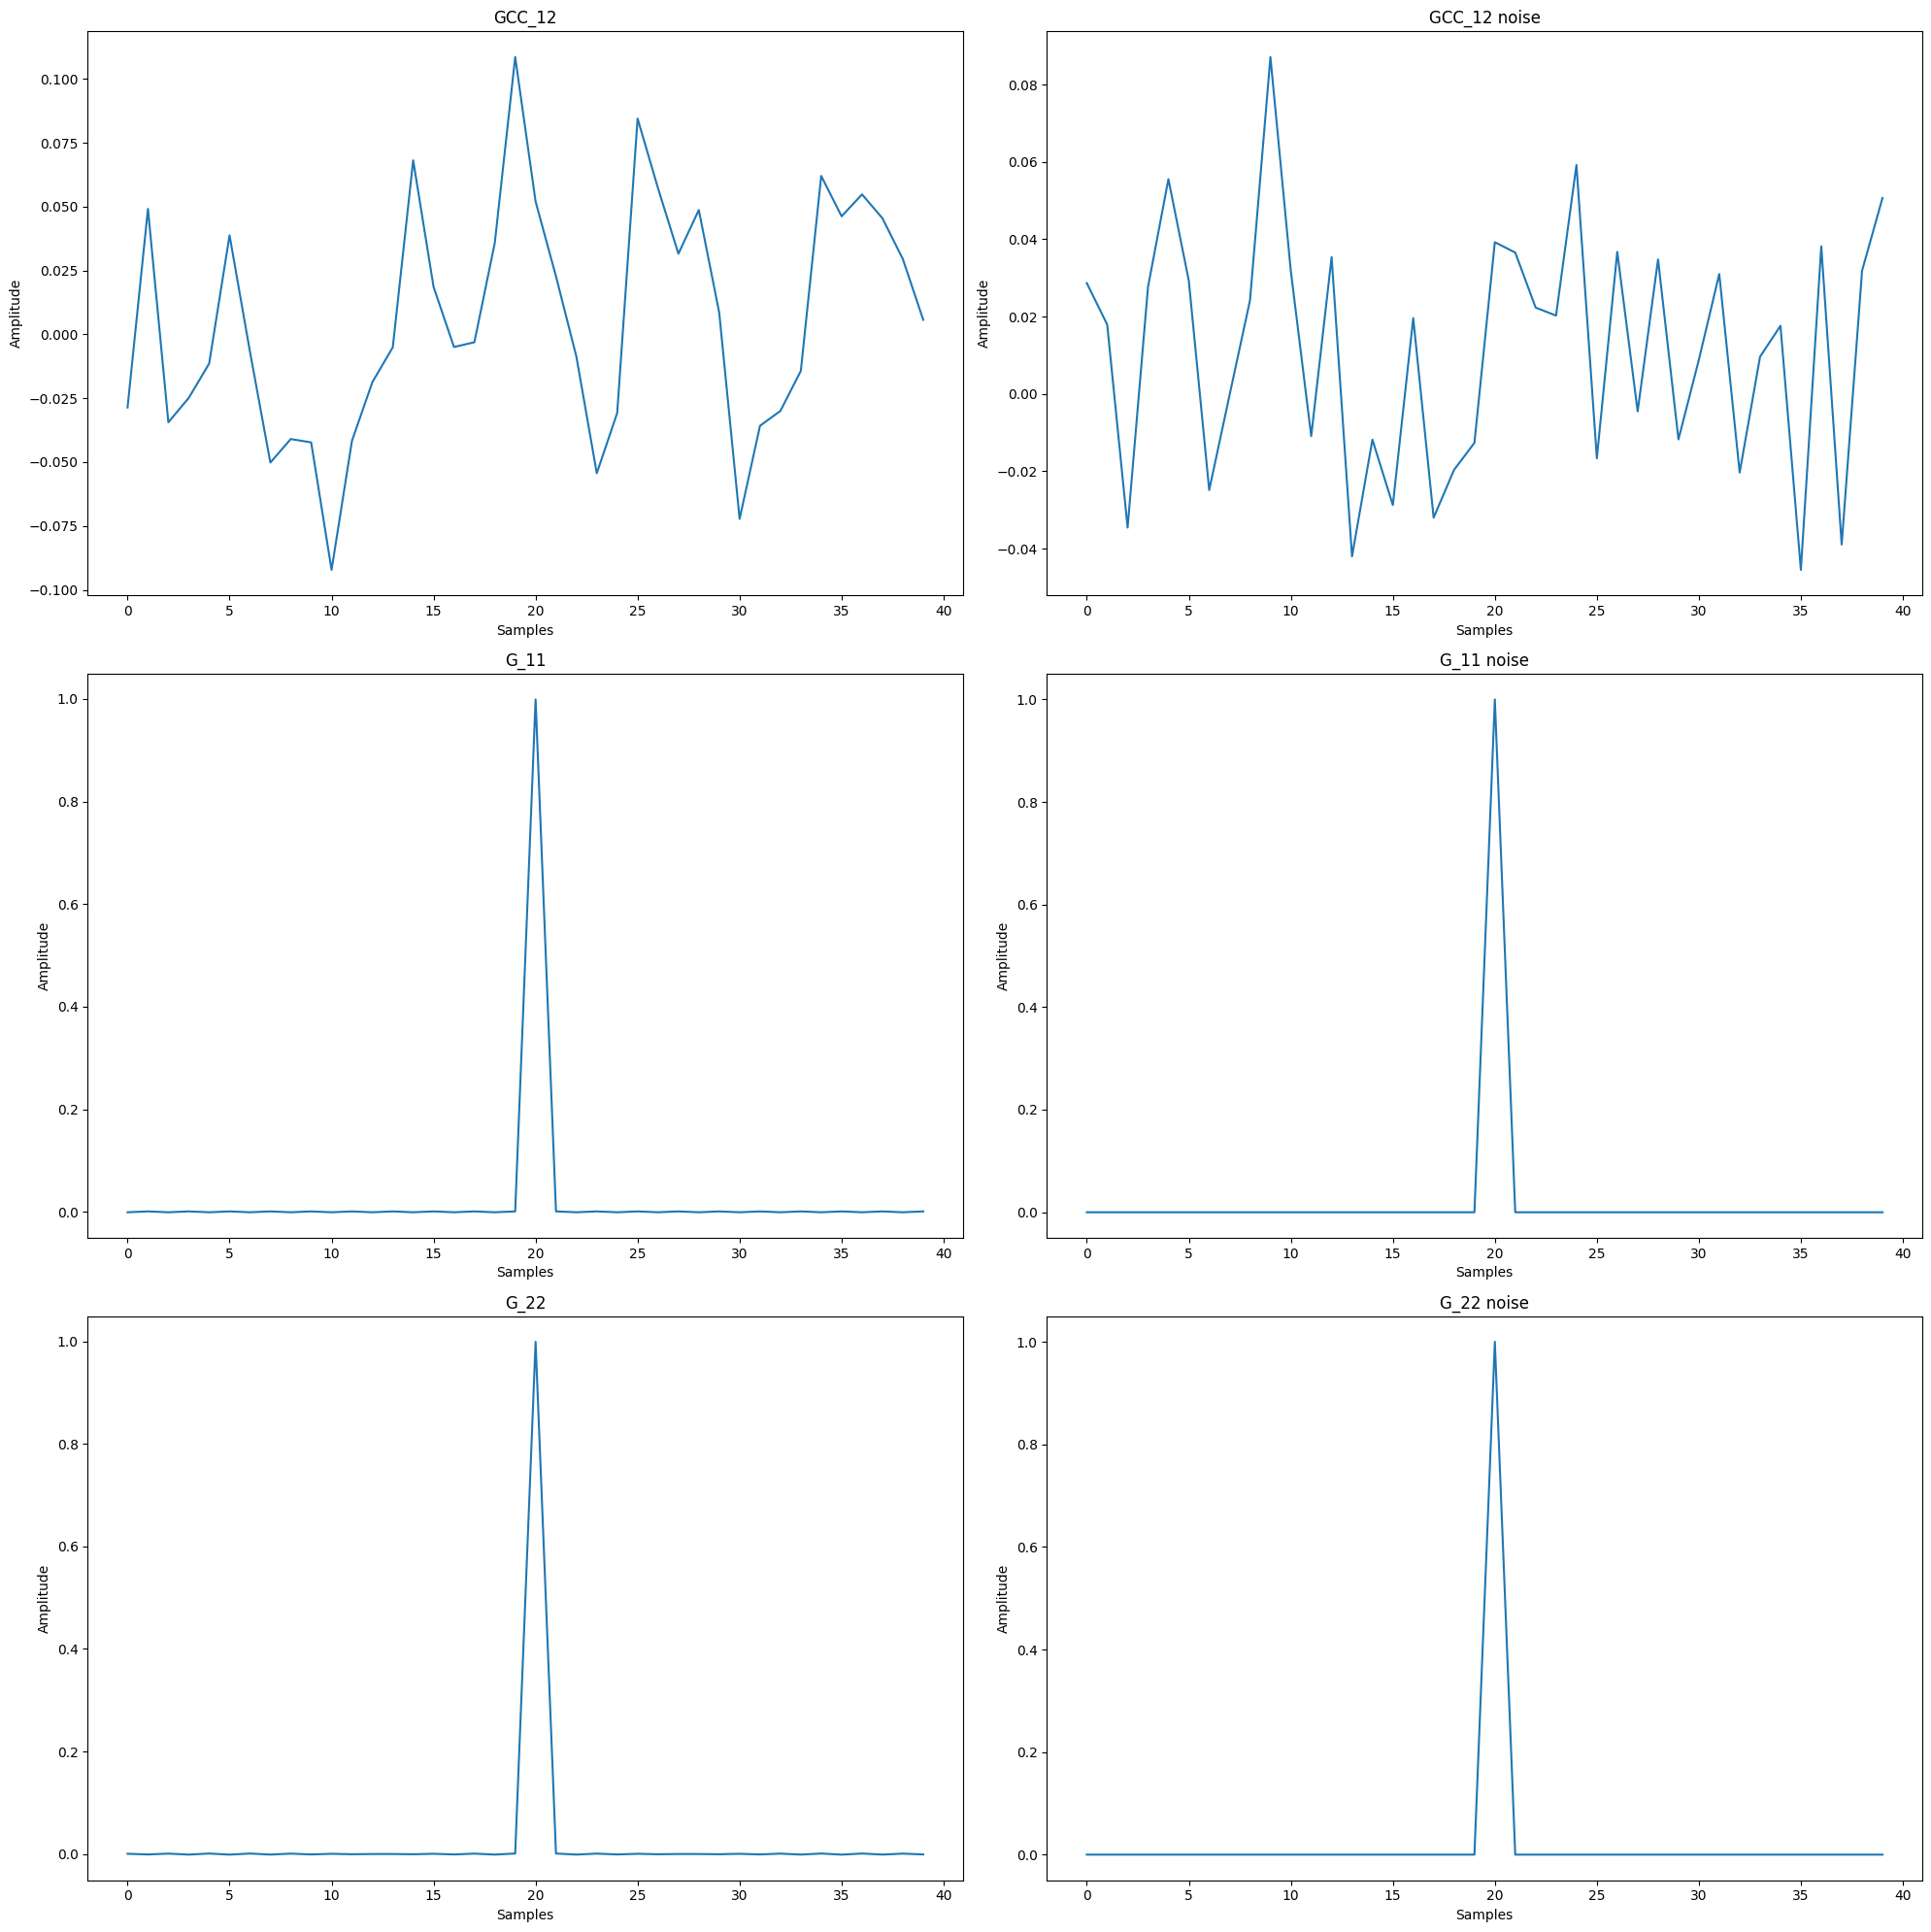

In [119]:
GCC_12 = create_gcc(sensor1, sensor2)
GCC_12_noise = create_gcc(sensor1_noise, sensor2_noise)

G_11 = create_gcc(sensor1, sensor1)
G_11_noise = create_gcc(sensor1_noise, sensor1_noise)

G_22 = create_gcc(sensor2, sensor2)
G_22_noise = create_gcc(sensor2_noise, sensor2_noise)


fig, ax = plt.subplots(3,2,figsize=(20,20))

ax = ax.ravel()

ax[0].plot(GCC_12)
ax[0].set_title('GCC_12')
ax[0].set_xlabel('Samples')
ax[0].set_ylabel('Amplitude')

ax[1].plot(GCC_12_noise)
ax[1].set_title('GCC_12 noise')
ax[1].set_xlabel('Samples')
ax[1].set_ylabel('Amplitude')

ax[2].plot(G_11)
ax[2].set_title('G_11')
ax[2].set_xlabel('Samples')
ax[2].set_ylabel('Amplitude')


ax[3].plot(G_11_noise)
ax[3].set_title('G_11 noise')
ax[3].set_xlabel('Samples')
ax[3].set_ylabel('Amplitude')

ax[4].plot(G_22)
ax[4].set_title('G_22')
ax[4].set_xlabel('Samples')
ax[4].set_ylabel('Amplitude')

ax[5].plot(G_22_noise)
ax[5].set_title('G_22 noise')
ax[5].set_xlabel('Samples')
ax[5].set_ylabel('Amplitude')


fig.tight_layout()


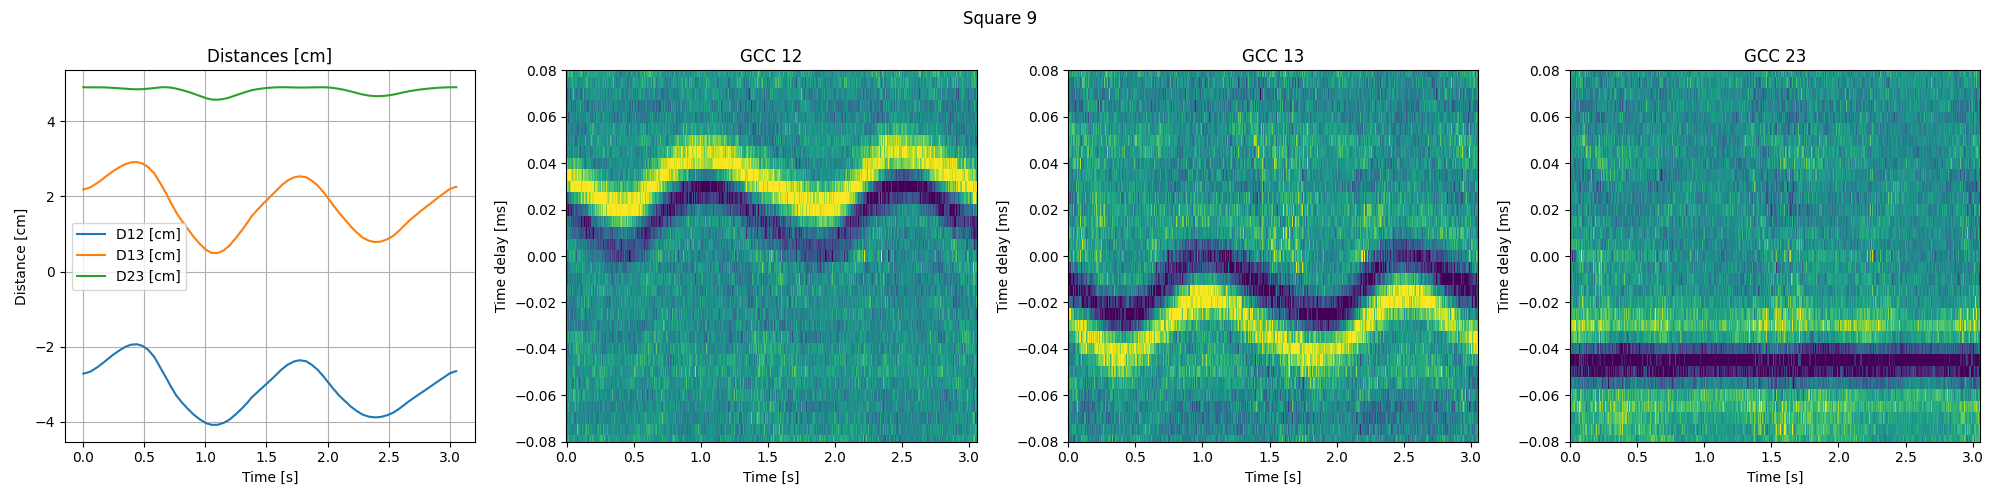